# Loan Prediction - Classification Solution

Bir finans kurumu, kredi ödemelerini geciktirme olasılığı daha düşük olan müşterileri belirlememize yardımcı olmamızı istiyor.
Şirket yönetimi, veri bilimi ekibinden iyi bir müşteri olabilecek kişileri belirlemek için bir tahmin modeli oluşturmasını istedi. Ayrıca, ekipten, müşterilerin kredi başvurusu yaparken modele dayalı olarak sorulacak sorular hazırlamasını istiyorlar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('LoansTrainingSet.csv')

In [3]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,Fully Paid,11520,Short Term,741.0,10+ years,Home Mortgage,33694.0,Debt Consolidation,$584.03,12.3,41.0,10,0,6760,16056,0.0,0.0
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,Fully Paid,3441,Short Term,734.0,4 years,Home Mortgage,42269.0,other,"$1,106.04",26.3,NaN,17,0,6262,19149,0.0,0.0
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,Fully Paid,21029,Short Term,747.0,10+ years,Home Mortgage,90126.0,Debt Consolidation,"$1,321.85",28.8,NaN,5,0,20967,28335,0.0,0.0
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,Fully Paid,18743,Short Term,747.0,10+ years,Own Home,38072.0,Debt Consolidation,$751.92,26.2,NaN,9,0,22529,43915,0.0,0.0
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Fully Paid,11731,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,$355.18,11.5,NaN,12,0,17391,37081,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256984 entries, 0 to 256983
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       256984 non-null  object 
 1   Customer ID                   256984 non-null  object 
 2   Loan Status                   256984 non-null  object 
 3   Current Loan Amount           256984 non-null  int64  
 4   Term                          256984 non-null  object 
 5   Credit Score                  195308 non-null  float64
 6   Years in current job          245508 non-null  object 
 7   Home Ownership                256984 non-null  object 
 8   Annual Income                 195308 non-null  float64
 9   Purpose                       256984 non-null  object 
 10  Monthly Debt                  256984 non-null  object 
 11  Years of Credit History       256984 non-null  float64
 12  Months since last delinquent  116601 non-nul

In [5]:
data.isnull().sum()

Loan ID                              0
Customer ID                          0
Loan Status                          0
Current Loan Amount                  0
Term                                 0
Credit Score                     61676
Years in current job             11476
Home Ownership                       0
Annual Income                    61676
Purpose                              0
Monthly Debt                         0
Years of Credit History              0
Months since last delinquent    140383
Number of Open Accounts              0
Number of Credit Problems            0
Current Credit Balance               0
Maximum Open Credit                  0
Bankruptcies                       529
Tax Liens                           23
dtype: int64

In [7]:
# Months since last delinquent cok fazla bos deger oldugu icin silmek daha faydali
del data['Months since last delinquent']

In [8]:
# Sayısal sütunlar
num_cols = data.select_dtypes(include=['float64', 'int64']).columns

In [9]:
# Ortalama ile dolduralım
imputer_mean = SimpleImputer(strategy='mean')
data[num_cols] = imputer_mean.fit_transform(data[num_cols])

In [10]:
# Kategorik sütunlar
cat_cols = data.select_dtypes(include=['object']).columns

In [11]:
# En sık görülen değer ile dolduralım
imputer_freq = SimpleImputer(strategy='most_frequent')
data[cat_cols] = imputer_freq.fit_transform(data[cat_cols])

In [12]:
data.isnull().sum()

Loan ID                      0
Customer ID                  0
Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Years in current job         0
Home Ownership               0
Annual Income                0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
dtype: int64

In [13]:
le = LabelEncoder()
data['Loan Status'] = le.fit_transform(data['Loan Status'])

In [14]:
# Binary kolonları encode et
for col in ['Term', 'Home Ownership', 'Purpose', 'Years in current job']:
    data[col] = le.fit_transform(data[col])

In [15]:
# Gereksiz ID sütunlarını çıkar
data = data.drop(['Loan ID', 'Customer ID'], axis=1)

In [16]:
# Feature ve target ayırma
X = data.drop('Loan Status', axis=1)
y = data['Loan Status']

In [17]:
X

,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,11520.0,1,741.000000,1,1,33694.000000,3,$584.03,12.3,10.0,0.0,6760.0,16056,0.0,0.0
1,3441.0,1,734.000000,4,1,42269.000000,9,"$1,106.04",26.3,17.0,0.0,6262.0,19149,0.0,0.0
2,21029.0,1,747.000000,1,1,90126.000000,3,"$1,321.85",28.8,5.0,0.0,20967.0,28335,0.0,0.0
3,18743.0,1,747.000000,1,2,38072.000000,3,$751.92,26.2,9.0,0.0,22529.0,43915,0.0,0.0
4,11731.0,1,746.000000,4,3,50025.000000,3,$355.18,11.5,12.0,0.0,17391.0,37081,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256979,3911.0,1,1251.116099,2,3,71952.716187,3,"$1,706.58",19.9,16.0,0.0,43992.0,44080,0.0,0.0
256980,5078.0,1,737.000000,1,2,77186.000000,3,"$1,376.47",19.1,9.0,0.0,1717.0,9758,0.0,0.0
256981,12116.0,1,7460.000000,9,1,52504.000000,3,$297.96,15.1,8.0,0.0,3315.0,20090,0.0,0.0
256982,12116.0,1,746.000000,9,1,52504.000000,3,$297.96,15.1,8.0,0.0,3315.0,20090,0.0,0.0


In [18]:
y

0         1
1         1
2         1
3         1
4         1
         ..
256979    1
256980    1
256981    0
256982    0
256983    1
Name: Loan Status, Length: 256984, dtype: int64

In [19]:
# Sayısal sütunlarda sayısal olmayan değerleri kontrol et
for col in num_cols:
    non_numeric = data[col][pd.to_numeric(data[col], errors='coerce').isna()]
    print(f"Column '{col}' has non-numeric values:\n{non_numeric}\n")

Column 'Current Loan Amount' has non-numeric values:
Series([], Name: Current Loan Amount, dtype: float64)

Column 'Credit Score' has non-numeric values:
Series([], Name: Credit Score, dtype: float64)

Column 'Annual Income' has non-numeric values:
Series([], Name: Annual Income, dtype: float64)

Column 'Years of Credit History' has non-numeric values:
Series([], Name: Years of Credit History, dtype: float64)

Column 'Number of Open Accounts' has non-numeric values:
Series([], Name: Number of Open Accounts, dtype: float64)

Column 'Number of Credit Problems' has non-numeric values:
Series([], Name: Number of Credit Problems, dtype: float64)

Column 'Current Credit Balance' has non-numeric values:
Series([], Name: Current Credit Balance, dtype: float64)

Column 'Bankruptcies' has non-numeric values:
Series([], Name: Bankruptcies, dtype: float64)

Column 'Tax Liens' has non-numeric values:
Series([], Name: Tax Liens, dtype: float64)



In [22]:
num_cols = [
    'Current Loan Amount', 'Credit Score', 'Annual Income', 
    'Years of Credit History',
    'Number of Open Accounts', 'Number of Credit Problems', 
    'Current Credit Balance', 'Maximum Open Credit', 
    'Bankruptcies', 'Tax Liens'
]

for col in num_cols:
    data[col] = pd.to_numeric(data[col].replace({'\\$': '', ',': ''}, regex=True), errors='coerce')

In [23]:
data.isnull().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Years in current job         0
Home Ownership               0
Annual Income                0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          4
Bankruptcies                 0
Tax Liens                    0
dtype: int64

In [24]:
data['Monthly Debt'].unique()

array(['$584.03', '$1,106.04 ', '$1,321.85 ', ..., '$707.08', '$47.11',
       '$2,525.82 '], dtype=object)

In [25]:
data['Annual Income'].unique()

array([33694., 42269., 90126., ..., 38649., 34749., 30854.])

In [26]:
data['Monthly Debt'] = data['Monthly Debt'].replace({'\\$': '', ',': ''}, regex=True).astype(float)

In [27]:
data['Annual Income'] = data['Annual Income'].replace({'\\$': '', ',': ''}, regex=True).astype(float)

In [28]:
for col in num_cols:
    data[col] = pd.to_numeric(data[col].replace({'\\$': '', ',': ''}, regex=True), errors='coerce')

In [29]:
data.isnull().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Years in current job         0
Home Ownership               0
Annual Income                0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          4
Bankruptcies                 0
Tax Liens                    0
dtype: int64

In [30]:
data.fillna(data.mean(), inplace=True)

In [31]:
data.isnull().sum()

Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Years in current job         0
Home Ownership               0
Annual Income                0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
dtype: int64

In [32]:
X

,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,11520.0,1,741.000000,1,1,33694.000000,3,$584.03,12.3,10.0,0.0,6760.0,16056,0.0,0.0
1,3441.0,1,734.000000,4,1,42269.000000,9,"$1,106.04",26.3,17.0,0.0,6262.0,19149,0.0,0.0
2,21029.0,1,747.000000,1,1,90126.000000,3,"$1,321.85",28.8,5.0,0.0,20967.0,28335,0.0,0.0
3,18743.0,1,747.000000,1,2,38072.000000,3,$751.92,26.2,9.0,0.0,22529.0,43915,0.0,0.0
4,11731.0,1,746.000000,4,3,50025.000000,3,$355.18,11.5,12.0,0.0,17391.0,37081,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256979,3911.0,1,1251.116099,2,3,71952.716187,3,"$1,706.58",19.9,16.0,0.0,43992.0,44080,0.0,0.0
256980,5078.0,1,737.000000,1,2,77186.000000,3,"$1,376.47",19.1,9.0,0.0,1717.0,9758,0.0,0.0
256981,12116.0,1,7460.000000,9,1,52504.000000,3,$297.96,15.1,8.0,0.0,3315.0,20090,0.0,0.0
256982,12116.0,1,746.000000,9,1,52504.000000,3,$297.96,15.1,8.0,0.0,3315.0,20090,0.0,0.0


In [33]:
# Feature ve target ayırma
X = data.drop('Loan Status', axis=1)
y = data['Loan Status']

In [34]:
# Normalizasyon
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# PCA
pca = PCA(n_components=0.95)  # varyansın %95'ini koru
X_pca = pca.fit_transform(X_scaled)

In [36]:
print(f"PCA sonrası boyut sayısı: {X_pca.shape[1]}")

PCA sonrası boyut sayısı: 13


In [37]:
# Veri setini ayır
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [38]:
# Model mimarisi
model = Sequential([
    Dense(64, input_dim=X_pca.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [39]:
# Derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Erken durdurma
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [41]:
# Eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=256,validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7424 - loss: 0.5021 - val_accuracy: 0.7533 - val_loss: 0.4805
Epoch 2/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7515 - loss: 0.4821 - val_accuracy: 0.7543 - val_loss: 0.4781
Epoch 3/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7525 - loss: 0.4794 - val_accuracy: 0.7530 - val_loss: 0.4762
Epoch 4/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7524 - loss: 0.4780 - val_accuracy: 0.7556 - val_loss: 0.4751
Epoch 5/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7535 - loss: 0.4771 - val_accuracy: 0.7551 - val_loss: 0.4746
Epoch 6/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7533 - loss: 0.4764 - val_accuracy: 0.7542 - val_loss: 0.4748
Epoch 7/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7536 - loss: 0.4759 - val_accuracy: 0.7543 - val_loss: 0.4742
Epoch 8/50
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7544 - loss: 0.4760 - val_accuracy: 0.

In [42]:
# Tahmin
y_pred = (model.predict(X_test) > 0.5).astype(int)

1607/1607 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step


In [43]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))

Confusion Matrix:
 [[ 5515 10646]
 [ 1628 33608]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.34      0.47     16161
           1       0.76      0.95      0.85     35236

    accuracy                           0.76     51397
   macro avg       0.77      0.65      0.66     51397
weighted avg       0.76      0.76      0.73     51397


ROC-AUC Score: 0.6475254440522361


In [44]:
# pip install shap

In [45]:
import shap

In [46]:
# SHAP analizi
explainer = shap.Explainer(model, X_pca)
shap_values = explainer(X_pca[:200])

PermutationExplainer explainer: 201it [00:22,  6.65it/s]                         


In [47]:
print(shap_values.shape)
print(X.shape)

(200, 13)
(256984, 15)


In [49]:
# Yalnızca ilk 13 özelliği kullan
X_subset = X.iloc[:200, :13]

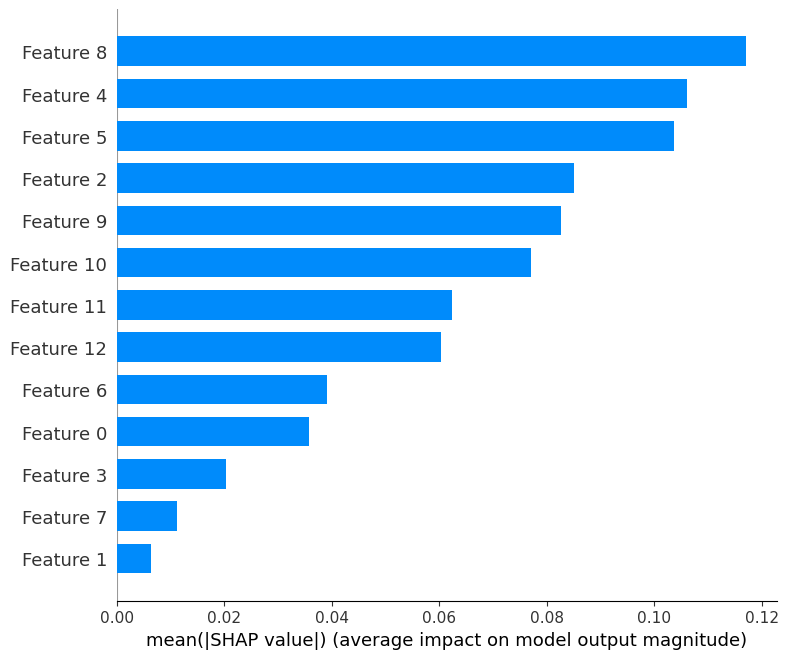

In [50]:
# X'in düzeltilmiş alt kümesiyle özet grafiği oluştur
shap.summary_plot(shap_values, X_subset, plot_type="bar")

In [51]:
# Özellik isimlerini ve türlerini görüntüleme
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256984 entries, 0 to 256983
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Current Loan Amount        256984 non-null  float64
 1   Term                       256984 non-null  int64  
 2   Credit Score               256984 non-null  float64
 3   Years in current job       256984 non-null  int64  
 4   Home Ownership             256984 non-null  int64  
 5   Annual Income              256984 non-null  float64
 6   Purpose                    256984 non-null  int64  
 7   Monthly Debt               256984 non-null  float64
 8   Years of Credit History    256984 non-null  float64
 9   Number of Open Accounts    256984 non-null  float64
 10  Number of Credit Problems  256984 non-null  float64
 11  Current Credit Balance     256984 non-null  float64
 12  Maximum Open Credit        256984 non-null  float64
 13  Bankruptcies               25

In [52]:
# Özellik isimlerini al
feature_names = X.columns.tolist()

In [53]:
# SHAP değerlerinin boyutunu kontrol et
print("SHAP values shape:", shap_values.shape)

SHAP values shape: (200, 13)


In [56]:
shap_values_corrected = shap_values[:, :-1]

In [57]:
# Özellik isimlerini al
feature_names = X.columns[:shap_values_corrected.shape[1]].tolist()

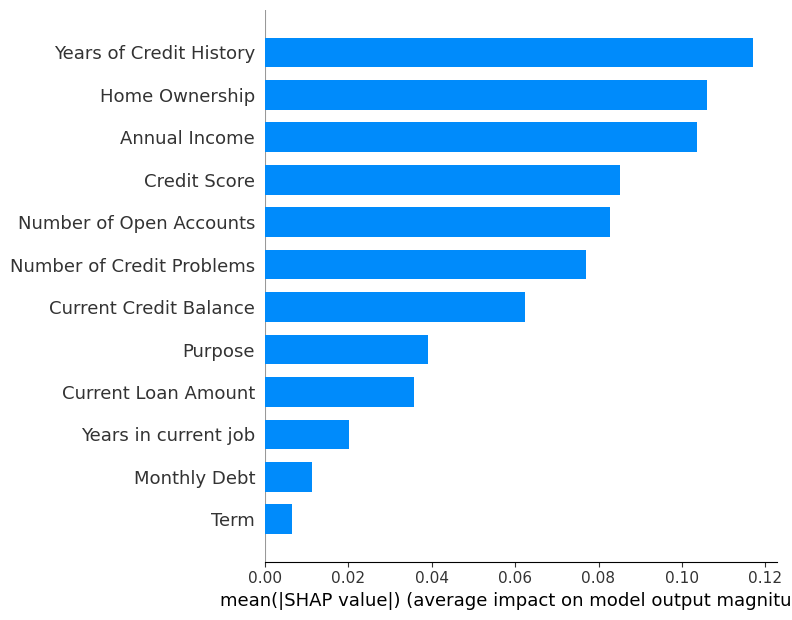

In [58]:
# Özet grafiği oluştur
shap.summary_plot(shap_values_corrected, X.iloc[:200, :shap_values_corrected.shape[1]], feature_names=feature_names, plot_type="bar")